# Partitioning SPP

This notebook follows up on `Comparing maps`, and describes how [Voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram) can be used to partition the NERC SPP region.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from IPython.display import display
import geopandas as gp
import pandas as pd
import geoplot
import numpy as np
from sklearn import neighbors

In [3]:
ecoinvent = gp.read_file("data/ecoinvent/electricity.gpkg")

mapping = {
    "US-ASCC": "ASCC",
    "US-FRCC": "FRCC",
    "US-HICC": "HICC",
    "MRO": "MRO",
    "NPCC": "NPCC",
    "US-RFC": "RFC",
    "US-SERC": "SERC",
    "US-SPP": "SPP",
    "US-TRE": "TRE",
    "WECC": "WECC",
}

ecoinvent = ecoinvent[ecoinvent['shortname'] == "US-SPP"]
ecoinvent['NERC'] = ecoinvent['shortname'].transform(lambda s: mapping[s])
ecoinvent = ecoinvent[['NERC', 'geometry']]

In [4]:
egrid_csv = pd.read_csv("data/egrid/egrid2018_data_v2.csv", skiprows=[1])

/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (32,50,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Filter some of the eGrid data to remove invalid or unusable rows.

In [5]:
# Only use values which have GIS coordinates
egrid_csv = egrid_csv[egrid_csv['Plant latitude'] < 90]

# SPP no longer exists
print("Removing {} plants labeled SPP".format(sum(egrid_csv['NERC region acronym'] == 'SPP')))
egrid_csv = egrid_csv[egrid_csv['NERC region acronym'] != 'SPP']

Removing 2 plants labeled SPP


In [6]:
egrid = gp.GeoDataFrame(
    egrid_csv, 
    geometry=gp.points_from_xy(egrid_csv['Plant longitude'], egrid_csv['Plant latitude']),
    crs = {'init' :'epsg:4326'}
).rename(columns={'NERC region acronym': 'NERC'})

These CRSes are 4326, but as they are formatted slightly differently, we still get complaints. Let's avoid these complaints.

In [7]:
ecoinvent.crs = egrid.crs

In [8]:
ecoinvent_buffered = ecoinvent.copy()
ecoinvent_buffered['geometry'] = ecoinvent_buffered.geometry.buffer(1)

/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [9]:
egrid_buffered = gp.sjoin(egrid, ecoinvent_buffered, how='inner', op='intersects', lsuffix='egrid', rsuffix='ecoinvent')

In [10]:
egrid = gp.sjoin(egrid, ecoinvent, how='inner', op='intersects', lsuffix='egrid', rsuffix='ecoinvent')

In [11]:
len(egrid), len(egrid_buffered)

(523, 945)

In [12]:
def set_bounds_by_layer(lyr, ax):
    xlim = ([lyr.total_bounds[0],  lyr.total_bounds[2]])
    ylim = ([lyr.total_bounds[1],  lyr.total_bounds[3]])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)    

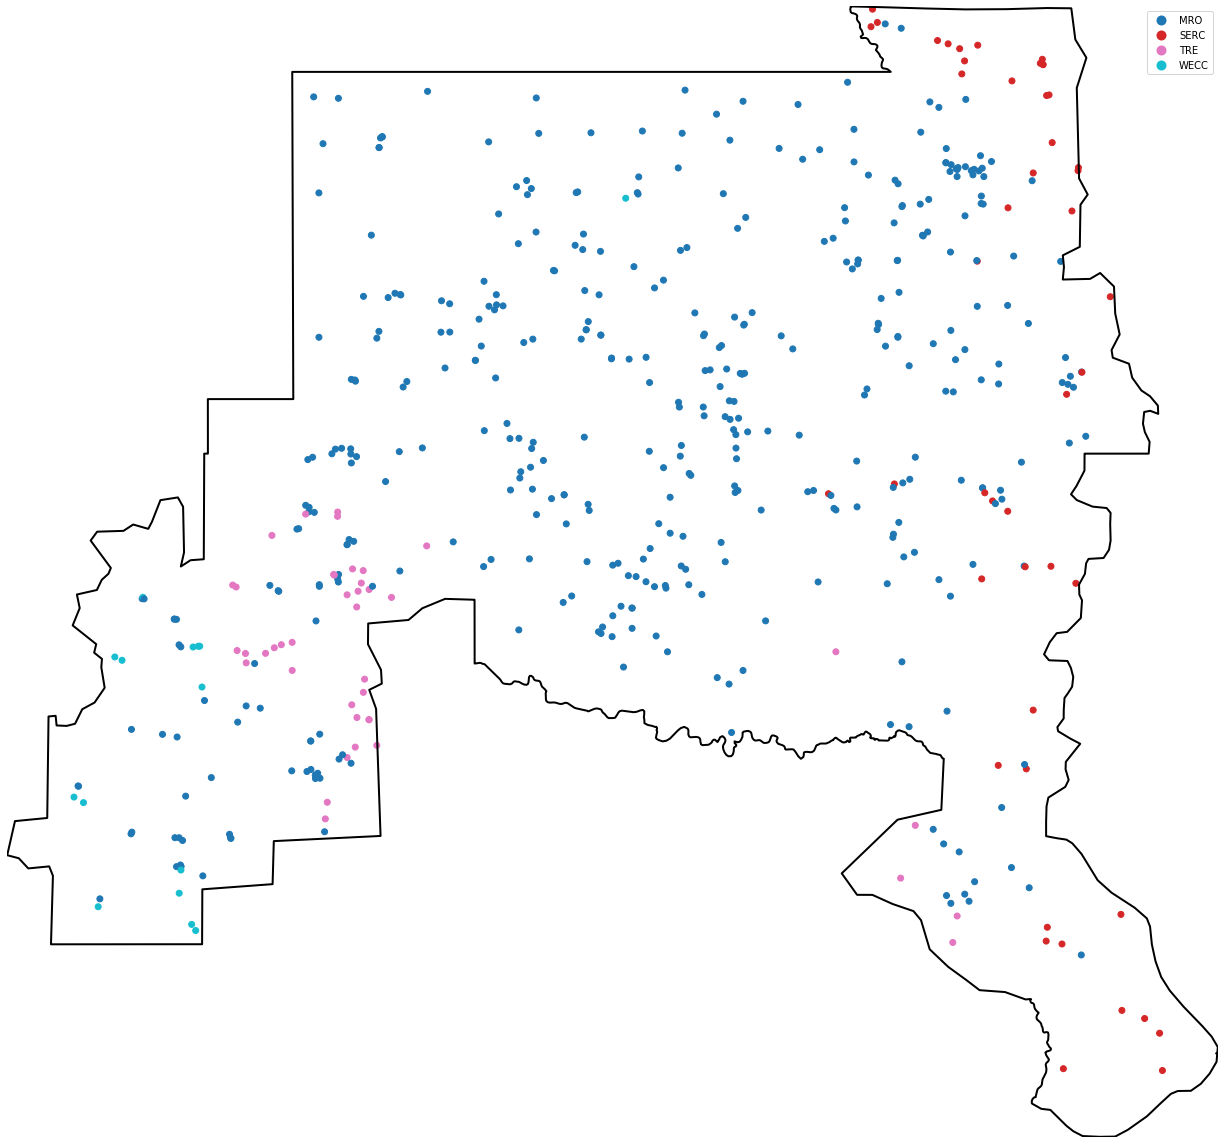

In [13]:
fig, ax = plt.subplots(figsize = (20,16)) 
egrid.plot(column='NERC_egrid', categorical=True, ax=ax, legend=True)
ecoinvent.boundary.plot(edgecolor='k', linewidth = 2, ax=ax) 

ax.axis('off')
set_bounds_by_layer(ecoinvent, ax)
plt.tight_layout()

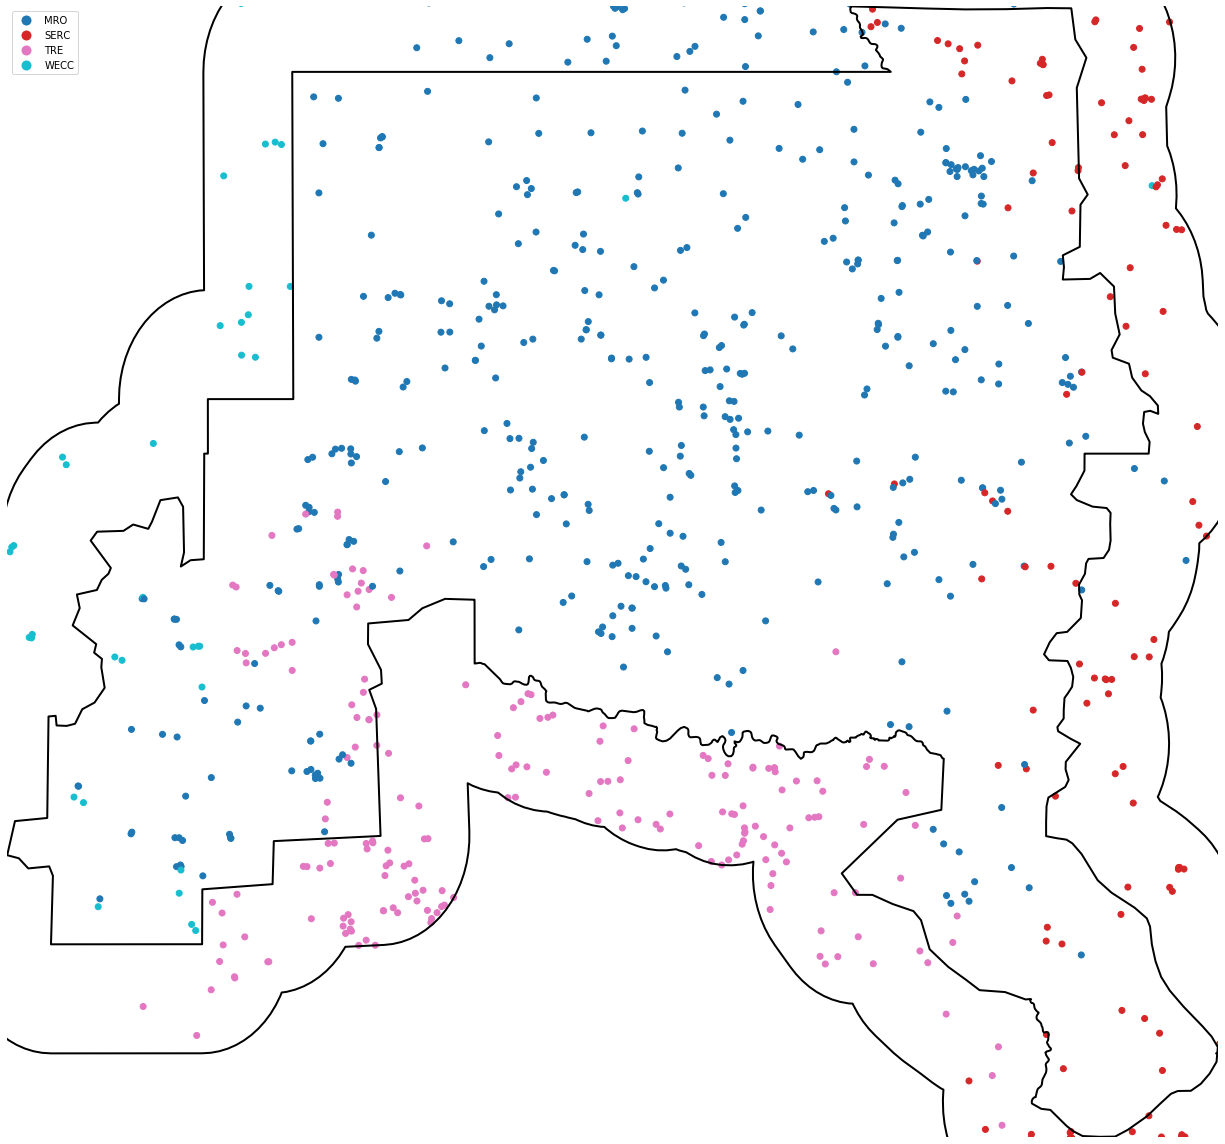

In [15]:
fig, ax = plt.subplots(figsize = (20,16)) 
egrid_buffered.plot(column='NERC_egrid', categorical=True, ax=ax, legend=True)
ecoinvent_buffered.boundary.plot(edgecolor='k', linewidth = 2, ax=ax) 
ecoinvent.boundary.plot(edgecolor='k', linewidth = 2, ax=ax) 


ax.axis('off')
set_bounds_by_layer(ecoinvent, ax)
plt.tight_layout()

In [17]:
nerc_mapping = dict(zip(sorted(egrid_buffered.NERC_egrid.unique()), range(10)))
nerc_mapping

{'MRO': 0, 'SERC': 1, 'TRE': 2, 'WECC': 3}

In [18]:
training = np.hstack([
    egrid_buffered['Plant longitude'].to_numpy().reshape([-1, 1]),
    egrid_buffered['Plant latitude'].to_numpy().reshape([-1, 1])
])
target = egrid_buffered.NERC_egrid.transform(lambda x: nerc_mapping[x]).to_numpy()

In [21]:
def parameterized_fit(N=500, n_neighbors=6):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(training, target)
    
    bounds = ecoinvent.geometry.bounds

    xs, ys = np.meshgrid(
        np.linspace(bounds.minx.min(), bounds.maxx.max(), N),
        np.linspace(bounds.miny.min(), bounds.maxy.max(), N),    
    )
    
    result = clf.predict(np.c_[xs.ravel(), ys.ravel()])
    return xs, ys, result.reshape(xs.shape)

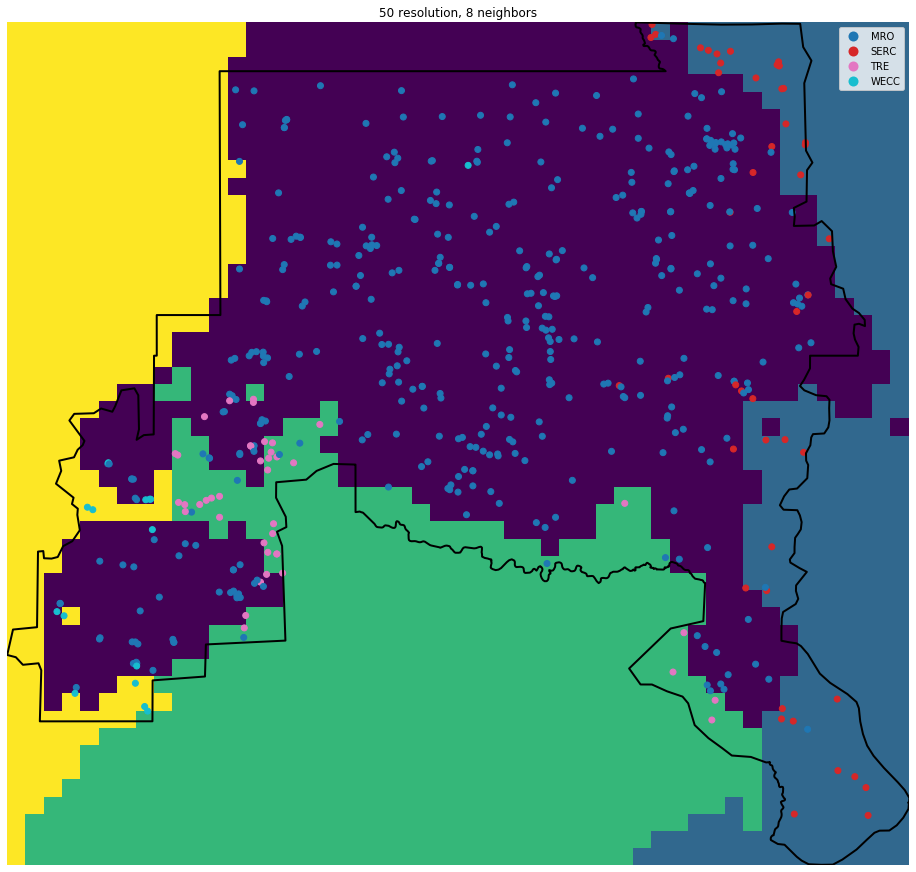

<Figure size 432x288 with 0 Axes>

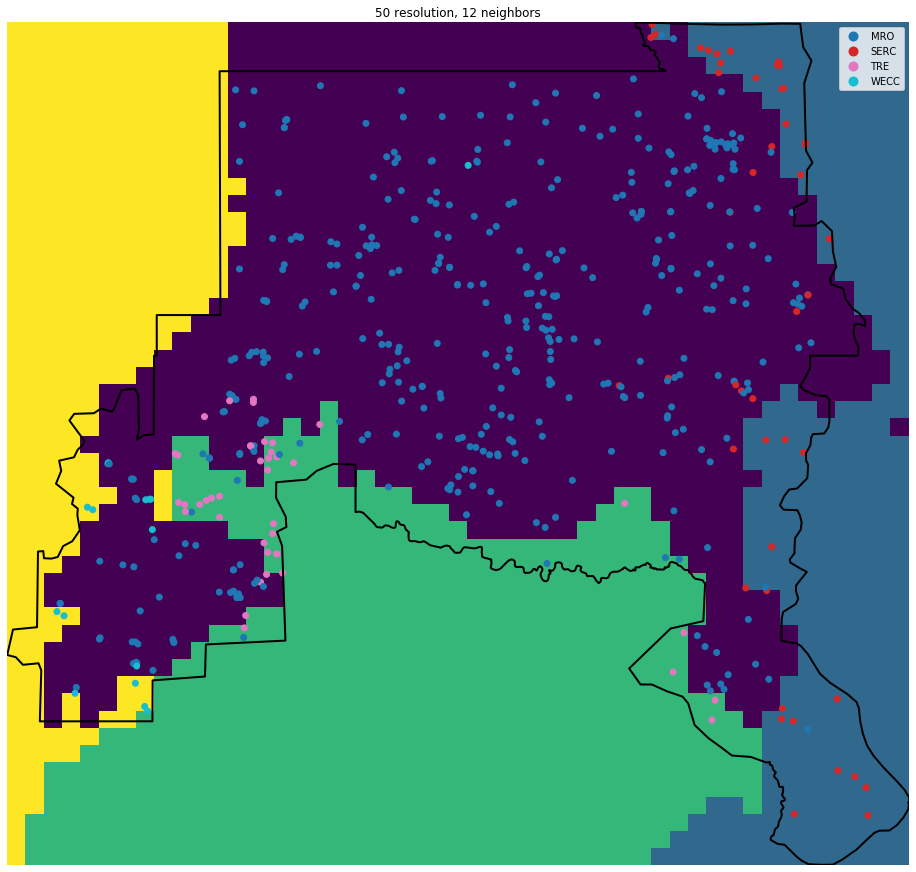

<Figure size 432x288 with 0 Axes>

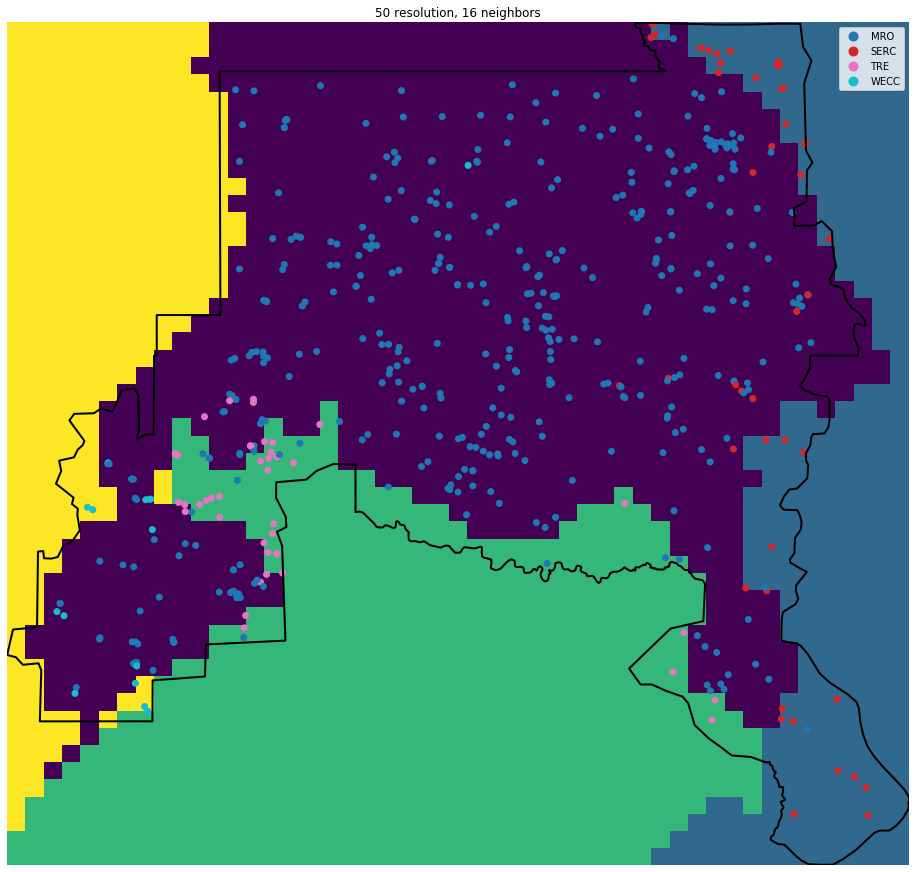

<Figure size 432x288 with 0 Axes>

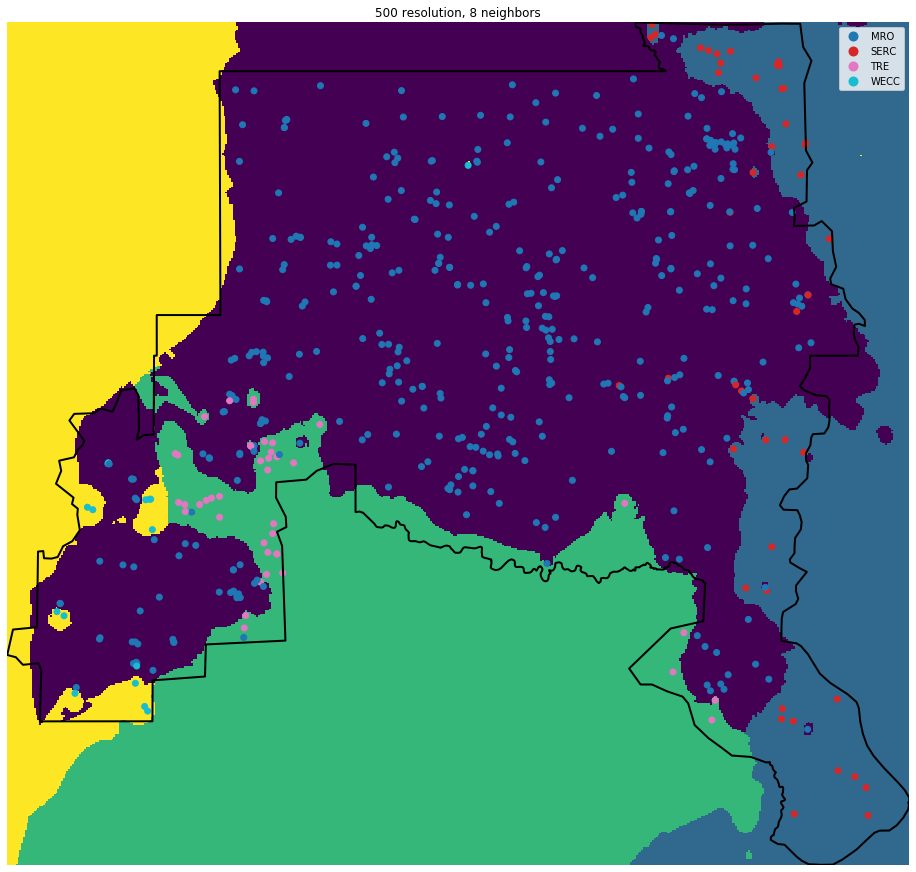

<Figure size 432x288 with 0 Axes>

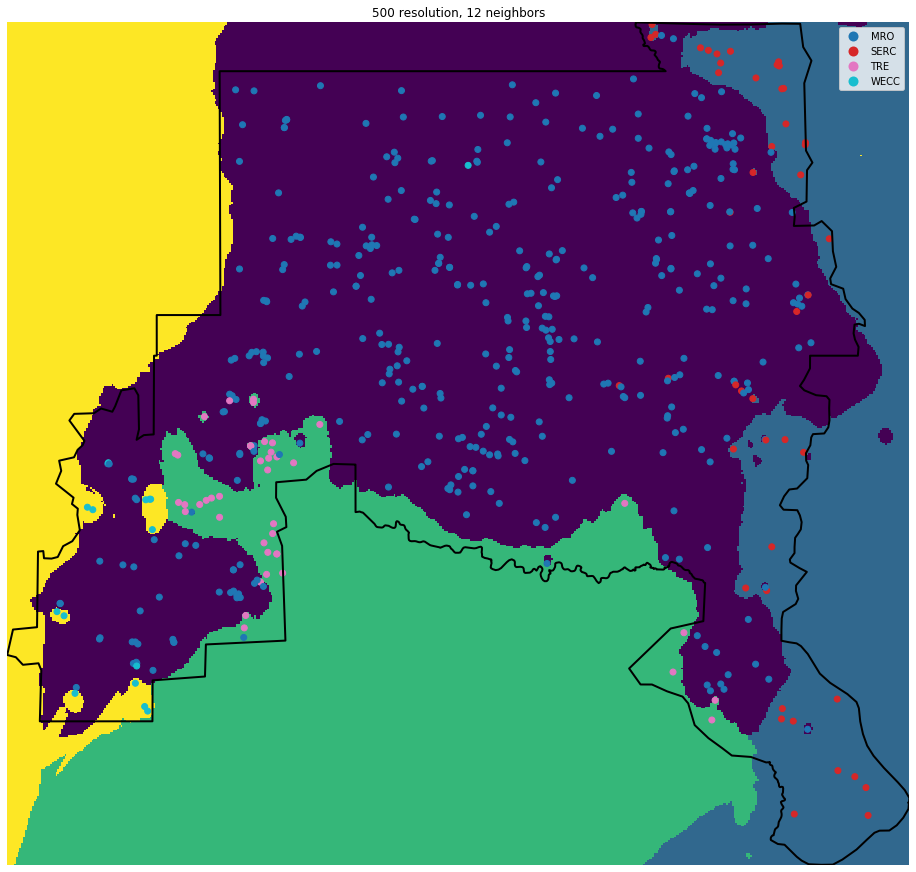

<Figure size 432x288 with 0 Axes>

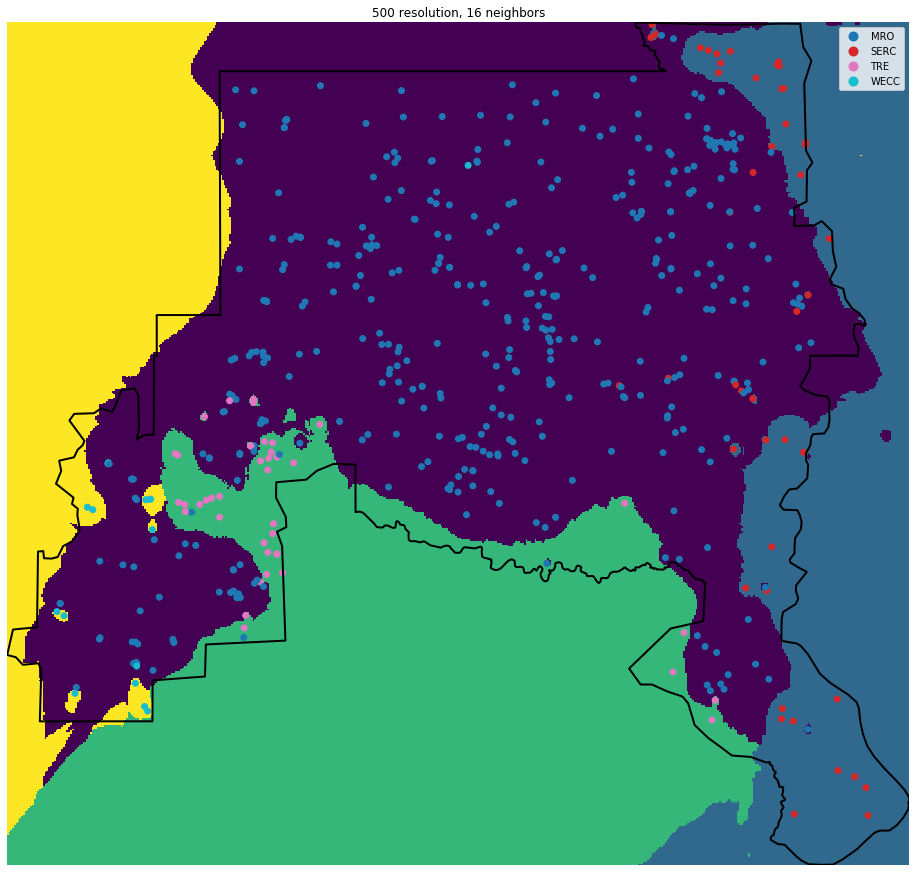

<Figure size 432x288 with 0 Axes>

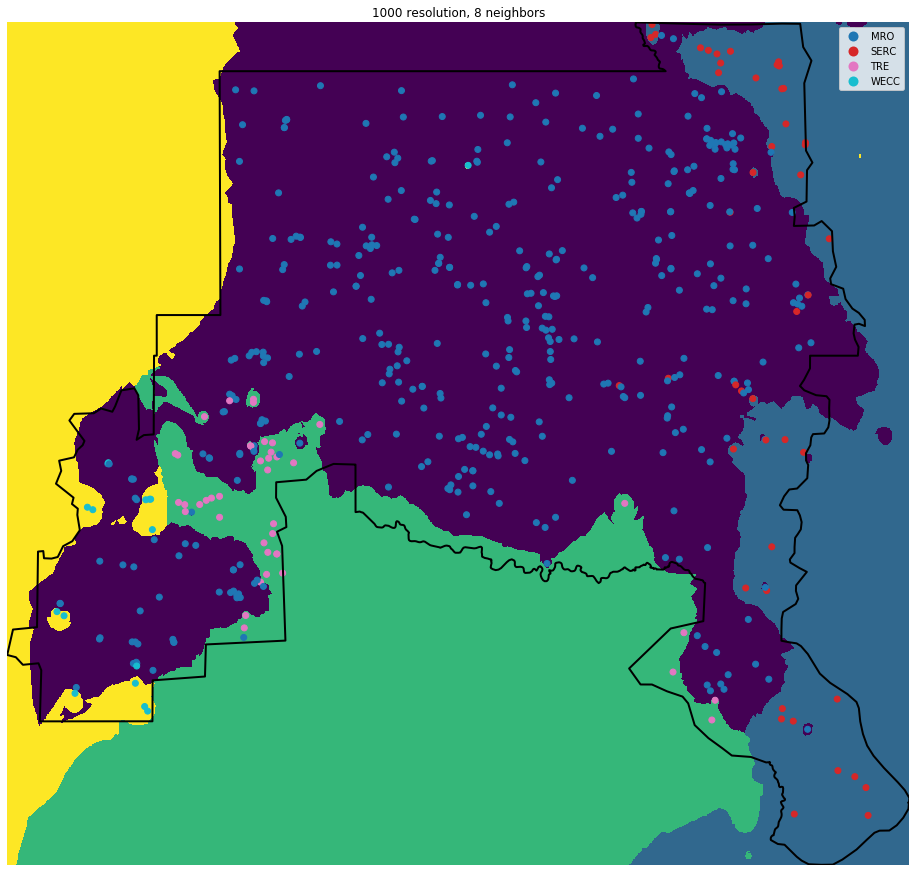

<Figure size 432x288 with 0 Axes>

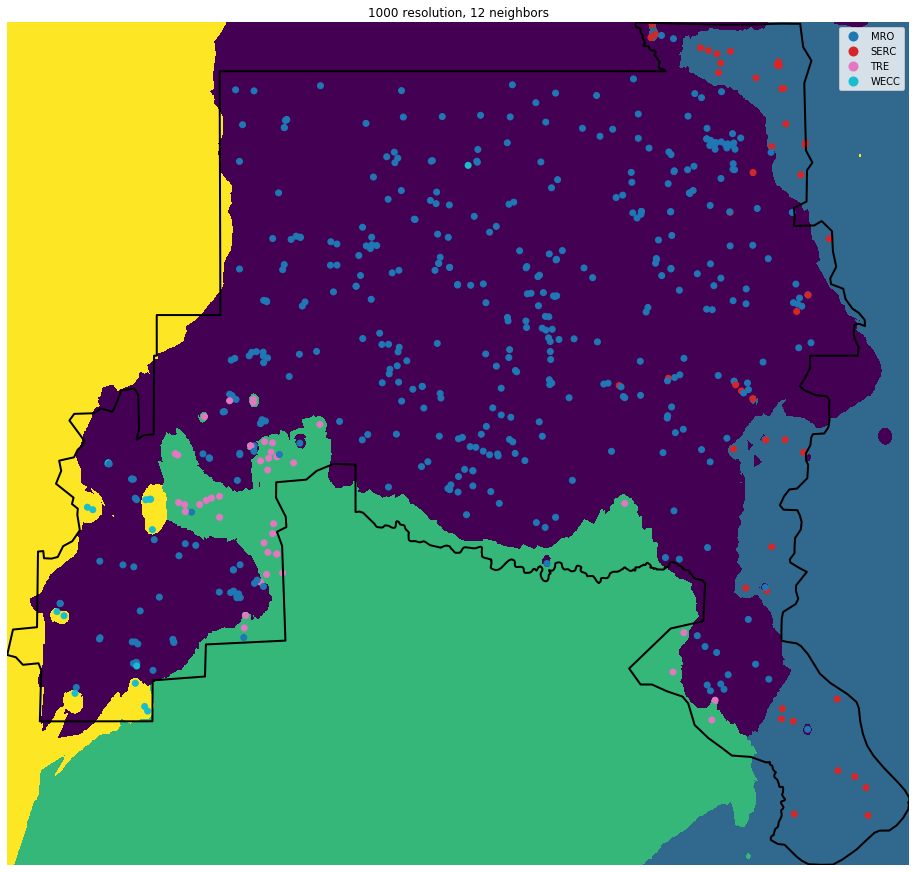

<Figure size 432x288 with 0 Axes>

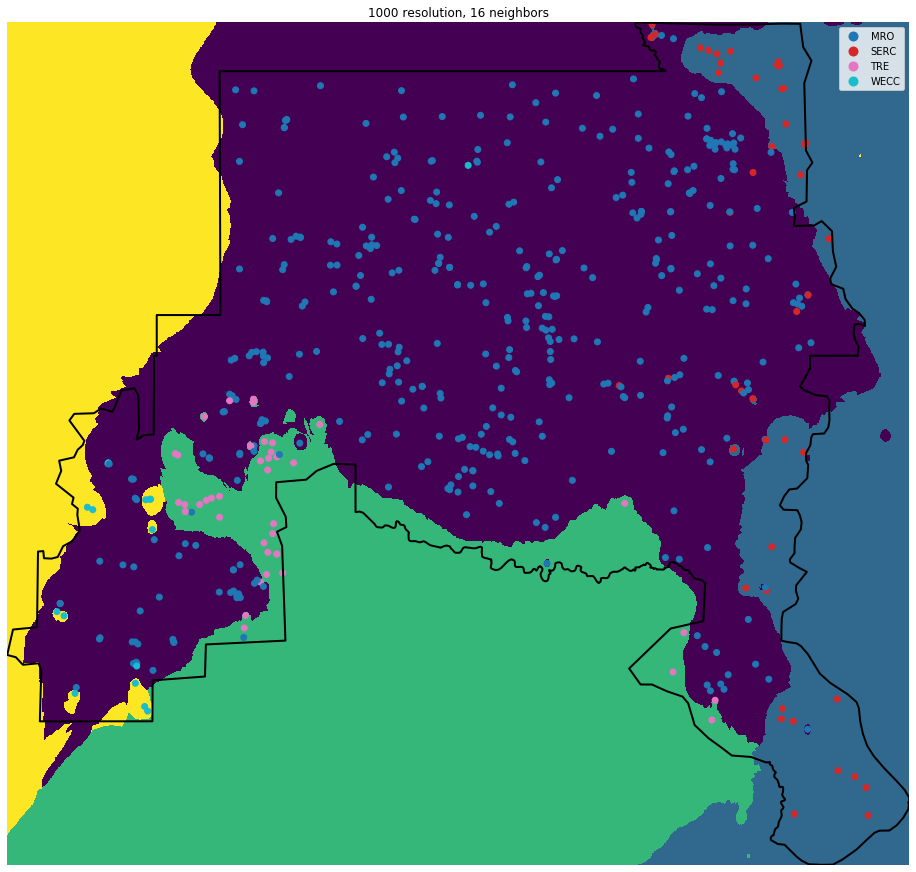

<Figure size 432x288 with 0 Axes>

In [24]:
for n in (50, 500, 1000):
    for nn in (8, 12, 16):

        fig, ax = plt.subplots(figsize = (16, 12)) 

        ax.pcolormesh(*parameterized_fit(n, nn))

        egrid.plot(column='NERC_egrid', categorical=True, ax=ax, legend=True)
        ecoinvent.boundary.plot(edgecolor='k', linewidth = 2, ax=ax) 

        ax.axis('off')
        set_bounds_by_layer(ecoinvent, ax)
        plt.tight_layout()
        plt.title(f"{n} resolution, {nn} neighbors")
        plt.show()
        plt.clf()

Discussion on how choice was made

In [28]:
longitude, latitude, data = parameterized_fit(1000, 12)

In [32]:
df = pd.DataFrame(
    data=zip(longitude.ravel(), latitude.ravel(), data.ravel()),
    columns=('latitude', 'longitude', 'value_int')
)

rev_mapping = {v: k for k, v in nerc_mapping.items()}
df['nerc'] = df['value_int'].transform(lambda s: rev_mapping[s])

In [35]:
gdf = gp.GeoDataFrame(
    df, 
    geometry=gp.points_from_xy(df.longitude, df.latitude)
)

In [ ]:
gdf.to_file("data/points.gpkg", driver="GPKG")